# Test of "filter" and "filtfilt" Functions from Ardour

resource: https://github.com/djpohly/ardour/tree/master/libs/qm-dsp/dsp/signalconditioning

### Import Packages and load Data Set

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# data path for matlab data
data_path = os.path.join( os.getcwd(), 'data', 'filtfilt_ECG_matlab_data.CSV')
filter_path = os.path.join( os.getcwd(), 'data', 'matlab_ECG_filter.CSV')

# load matlab results as pandas Dataframe
df_matlab_results = pd.read_csv(data_path, sep=';')
df_filter = pd.read_csv(filter_path, sep=';')

In [3]:
df_index = df_matlab_results.index.values.flatten()                 # index of dataframe entries (0 - 500)
df_wform = df_matlab_results.wform.values.flatten()                 # base signal: ECG-Waveform without noise
df_wform_noisy = df_matlab_results.wform_noisy.values.flatten()     # input signal for analysis: ECG-Waveform with noise
df_matlab_filtfilt = df_matlab_results.y_filtfilt.values.flatten()  # MATLAB "filtfilt" function results for input signal
df_matlab_filter = df_matlab_results.y_filter.values.flatten()      # MATLAB "filter" function results for input signal

df_num_filt = df_filter.num_filt.values.flatten()  # numerator (B) of used filter (butterworth filter, order: 12)
df_den_filt = df_filter.den_filt.values.flatten()  # denominator (A) of used filter (butterworth filter, order: 12)

### Plot used Data 

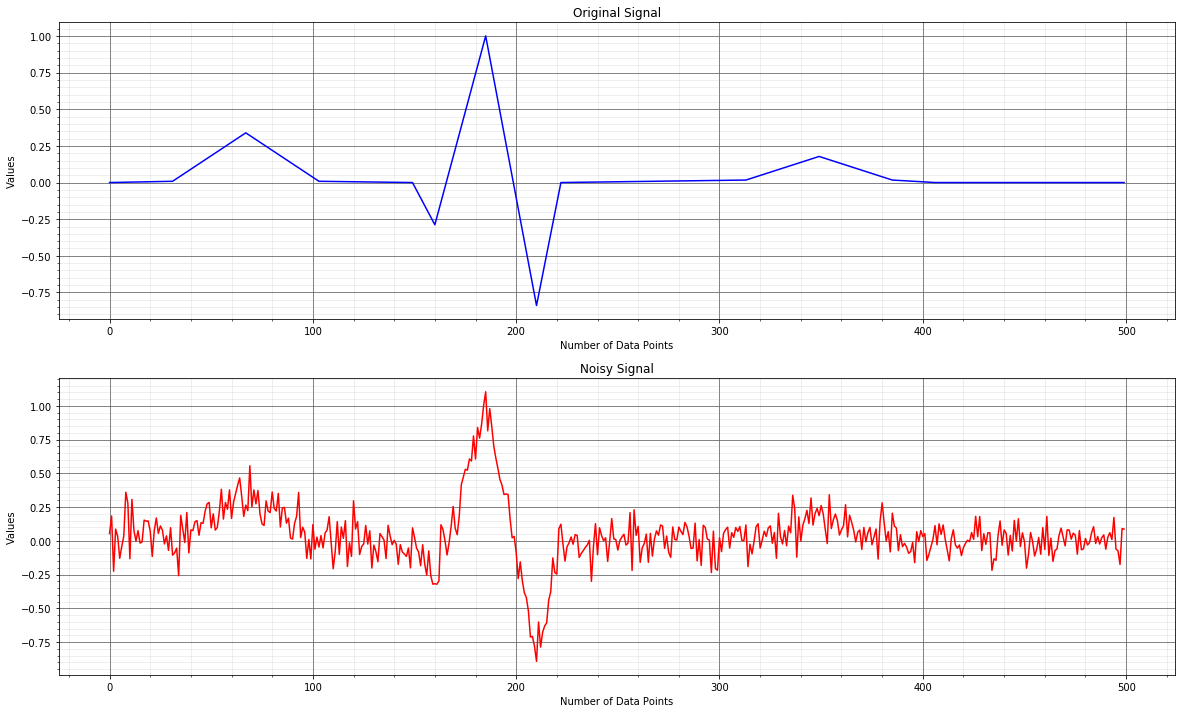

In [4]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,12))

ax0.plot(df_index, df_wform, color='blue', label ='orginal signal')
ax1.plot(df_index, df_wform_noisy, color='red', label ='noisy signal')

ax0.set_title('Original Signal')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Noisy Signal')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

## Ardour "filter" Function (conventional filter with phase-distortion)

In [5]:
def filterArdour(filt_ord, filt_ACoeffs, filt_BCoeffs, input_signal, input_signal_len):
    u = input_signal                # input signal
    length = input_signal_len       # length of raw input signal (caution: length without edge reflections!, see function: filtfilt)
    y = np.zeros((length,))         # output signal; initialize with zeros
    
    inBuffer = np.zeros((filt_ord+1,))  # buffer for input signal with window length of (filter_ord+1) ; initialize with zeros
    outBuffer = np.zeros((filt_ord+1,)) # buffer for output signal with window length of (filter_ord+1) ; initialize with zeros
    
    for j in range(0, length):

        # move input buffer and sample value of input signal (required for feedforward path of IIR-Filter)
        for i in range(0, filt_ord):
            inBuffer[filt_ord-i] = inBuffer[filt_ord-i-1]
        inBuffer[0] = u[j]   # sample input signal of current time step

        # reset output value for current time step
        y_temp = 0

        # calculate feedforward path (B of IIR-Filter)
        for i in range(0, filt_ord):
            y_temp = y_temp + filt_BCoeffs[i] * inBuffer[i]

        # calculate feedback path (A of IIR-Filter)
        for i in range(0, filt_ord):
            y_temp = y_temp - filt_ACoeffs[i+1] * outBuffer[i]

        # write calculated filter output of current time step into output array
        y[j] = y_temp

        # move output buffer and sample value of output signal (required for feedback path of IIR-Filter)
        for i in range(0, filt_ord-1):
            outBuffer[filt_ord-i-1] = outBuffer[filt_ord-i-2]
        outBuffer[0] = y_temp
    
    return y;


### Test of "filter" Function

In [6]:
y_filterArdour = filterArdour(
    filt_ord = 12, 
    filt_ACoeffs = df_den_filt, 
    filt_BCoeffs = df_num_filt, 
    input_signal = df_wform_noisy, 
    input_signal_len = 500)

# calculate error between MATLAB filter function and Ardour filter function
filter_error = np.abs(df_matlab_filter - y_filterArdour)

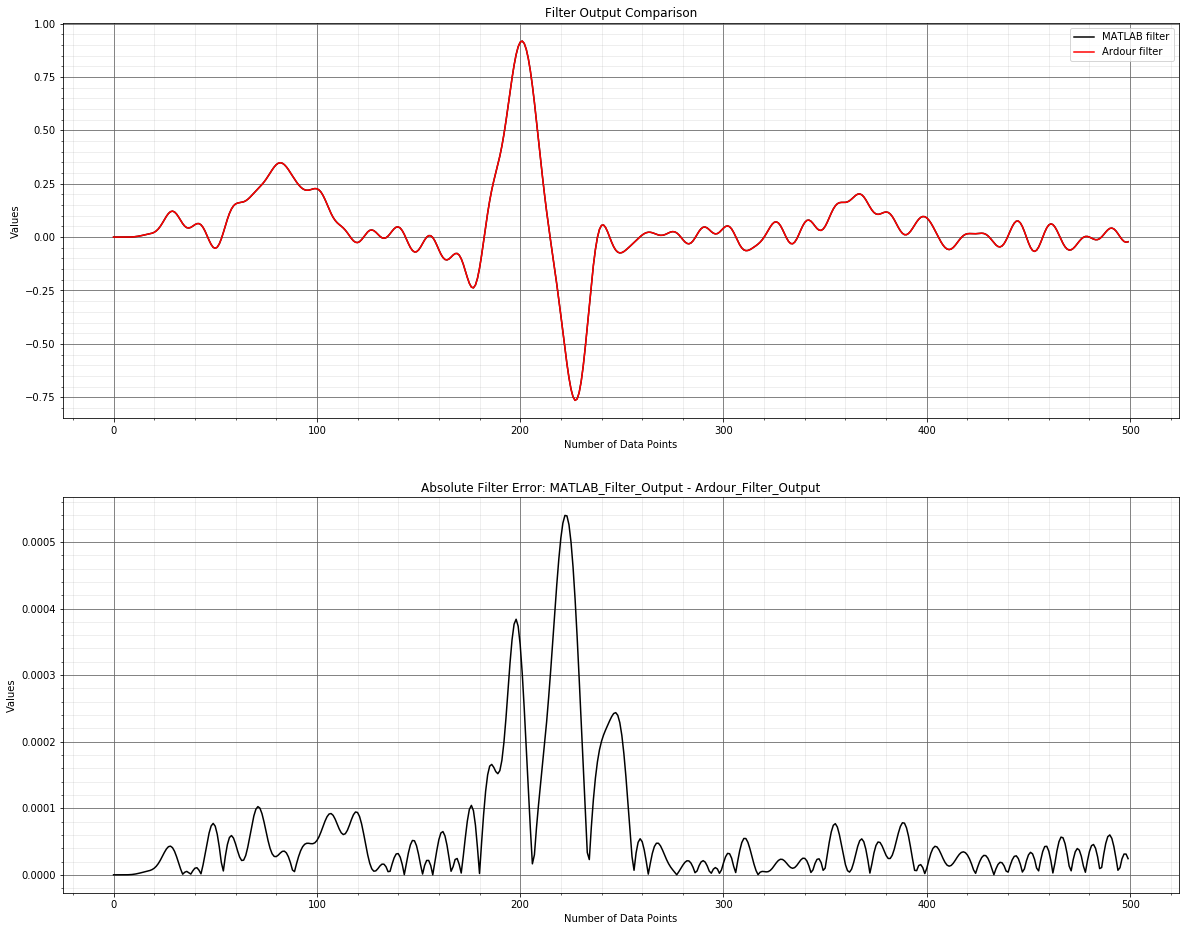

In [7]:
# plot comparison and error
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,16))

ax0.plot(df_matlab_results.index, df_matlab_filter, color='black', label ='MATLAB filter')
ax0.plot(df_matlab_results.index, y_filterArdour, color='red', label ='Ardour filter')
ax1.plot(df_matlab_results.index, filter_error, color='black', label ='Filter Error')

ax0.set_title('Filter Output Comparison')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Absolute Filter Error: MATLAB_Filter_Output - Ardour_Filter_Output')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

## Ardour "filtfilt" Function (conventional filter with phase-distortion)

In [8]:
def filtfiltArdour(filt_ACoeffs, filt_BCoeffs, input_signal, input_signal_len):
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Variable initilization and preprocessing
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    u = input_signal            # input signal
    length = input_signal_len   # length of raw input signal (caution: length without edge reflections!, see function: filtfilt)
    y = np.zeros((length,))     # output signal; initialize with zeros
    
    filtACoeffs = filt_ACoeffs  # filter numerator coefficients
    filtBCoeffs = filt_BCoeffs  # filter denominator coefficients

    na = len(filtACoeffs)       # number of filter feedback coefficients (A)
    nb = len(filtBCoeffs)       # number of filter feedforward coefficients (B)
    nFilt = max(na,nb)          # max. number of given filter coefficients 
    filtOrd = nFilt - 1         # filter order
    nFact = 3 * ( nFilt - 1)    # length of edge transients ( 3 times filter order)
    nExt = length + 2 * nFact   # padding before and after signal
    
    nfilt = max(na,nb)          # 
    nfact = max(1,3*(nfilt-1))  # length of edge transients
    
    sample0 = 2*u[0]            # used for edge transfer reflection
    sampleN = 2*u[length-1]     # used for edge transfer reflection
    index = 0;                  # index variable for loops
    filtScratchIn = np.zeros((nExt,))  # function intern input sequence 
    filtScratchOut = np.zeros((nExt,)) # function intern output sequence
    
    # zero pad shorter coeff arrays as needed
    if (nb < nFilt):
        filtBCoeffs = np.zeros((nFilt,))
    elif (na < nFilt):
        filtACoeffs = np.zeros((nFilt,))
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Edge Transfer Reflection
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #   starting edge transfer reflection
    for i in range(nFact, 0, -1):
        filtScratchIn[index] = sample0 - u[i]
        index = index + 1
        
    #   ending edge transfer reflection
    index = 0;
    for i in range(0, nFact):
        filtScratchIn[ (nExt - nFact) + index ] = sampleN - u[ (length - 2) - i ]
        index = index + 1
        
    # (normal/unedited) raw signal inbetween edge transfer padding
    for i in range(0, length):
        filtScratchIn[i + nFact] = u[i]
        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 1st filtering (forward filtering)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    y_filtfiltArdour = filterArdour(filt_ord = filtOrd, 
                            filt_ACoeffs = filtACoeffs, 
                            filt_BCoeffs = filtBCoeffs, 
                            input_signal = filtScratchIn, 
                            input_signal_len = nExt)    
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 2nd filtering (backward filtering)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #   reverse the filtered signal:
    for i in range(0, nExt):
        filtScratchIn[i] = y_filtfiltArdour[ nExt -i -1 ]
        
    #   filter the reversed signal again (backward filtering)
    y_filtfiltArdour = filterArdour(filt_ord = filtOrd, 
                        filt_ACoeffs = filtACoeffs, 
                        filt_BCoeffs = filtBCoeffs, 
                        input_signal = filtScratchIn, 
                        input_signal_len = nExt)
    
    #   reverse the reversed signal again to get the normal signal
    for i in range(0, nExt):
        filtScratchIn[i] = y_filtfiltArdour[ nExt -i -1 ]
        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Remove Edge Transients padding for Output Signal
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for i in range(0, length):
        y[i] = filtScratchIn[i + nFact]
        
    return y

In [9]:
y_filtfiltArdour = filtfiltArdour(
                            filt_ACoeffs = df_den_filt, 
                            filt_BCoeffs = df_num_filt, 
                            input_signal = df_wform_noisy, 
                            input_signal_len = 500)  

# calculate error between MATLAB filtfilt function and Ardour filtfilt function
filtfilt_error = np.abs(df_matlab_filtfilt - y_filtfiltArdour)

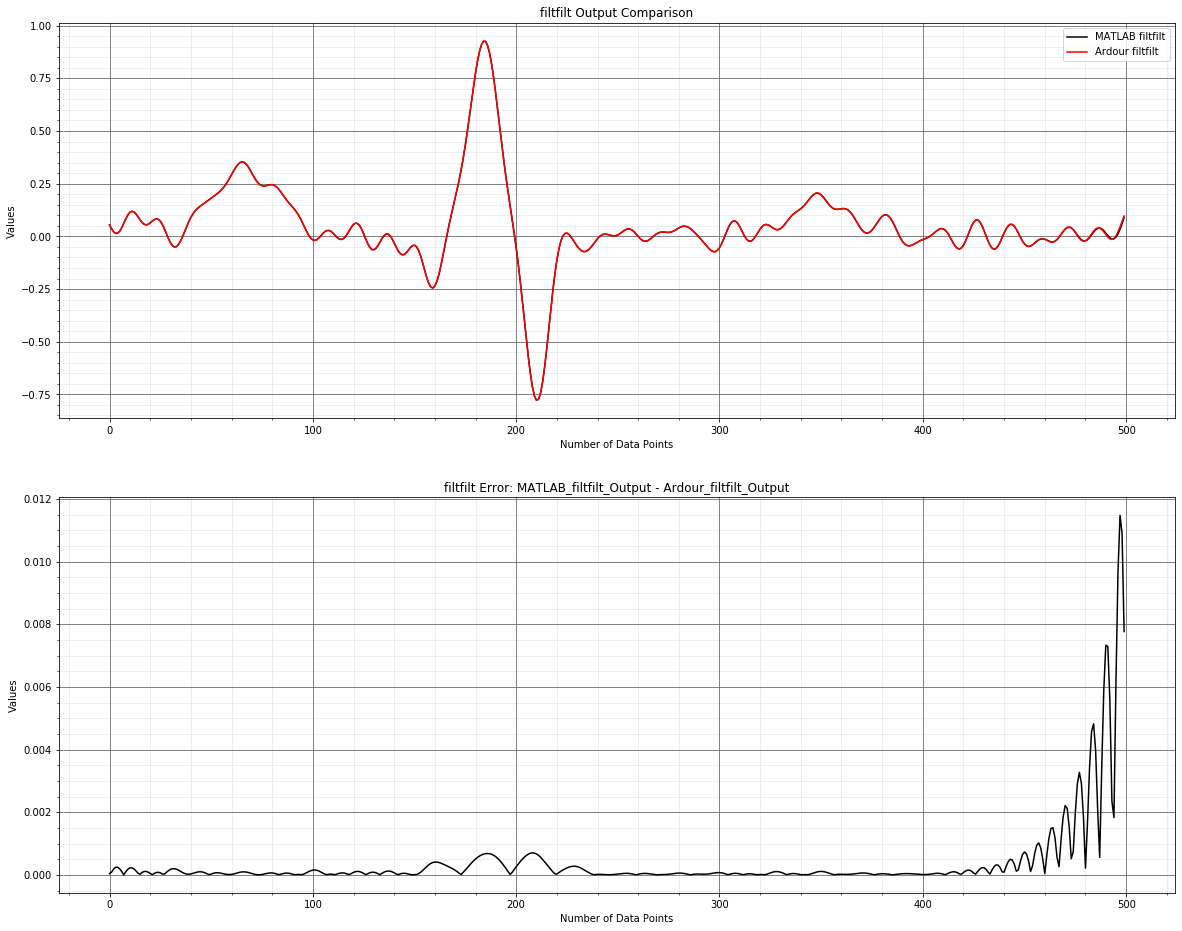

In [10]:
# plot comparison and error
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,16))

ax0.plot(df_matlab_results.index, df_matlab_filtfilt, color='black', label ='MATLAB filtfilt')
ax0.plot(df_matlab_results.index, y_filtfiltArdour, color='red', label ='Ardour filtfilt')
ax1.plot(df_matlab_results.index, filtfilt_error, color='black', label ='filtfilt error')

ax0.set_title('filtfilt Output Comparison')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('filtfilt Error: MATLAB_filtfilt_Output - Ardour_filtfilt_Output')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# Function Tests

### isolated test of: Edge Transformation Reflection (used in filtfilt)

In [11]:
# variables
u = df_wform_noisy           # input signal
length = len(df_wform_noisy) # length of input signal
y = np.zeros((length,))      # output signal

filt_ord = 12               # filter order
filt_ACoeffs = df_den_filt  # filter A coeffs
filt_BCoeffs = df_num_filt  # filter B coeffs

nFilt = filt_ord + 1
nFact = 3 * ( nFilt - 1)    # 3 times the filter order for padding
nExt = length + 2 * nFact   # length of padded signal (padding before and after raw signal: "nFact + length + nFact")

filtScratchIn = np.zeros((nExt,))  # function intern input sequence 
filtScratchOut = np.zeros((nExt,)) # fuction intern output sequence

# edge transformation reflection
sample0 = 2 * u[0]          # two times the amplitude of first signal value 
sampleN = 2 * u[length-1]   # two times the amplitude of last signal value

In [12]:
# Edge Transformation of start transient of signal
# - index: from [0]  to  [3*filt_ord-1]
index = 0;
for i in range(nFact, 0, -1):
    filtScratchIn[index] = sample0 - u[i]
    
    # print the calculation for control purposes
    print('filtScratchIn[',index,'] = 2 * u[ 0 ] - u[',i,']')
    index = index + 1   

filtScratchIn[ 0 ] = 2 * u[ 0 ] - u[ 36 ]
filtScratchIn[ 1 ] = 2 * u[ 0 ] - u[ 35 ]
filtScratchIn[ 2 ] = 2 * u[ 0 ] - u[ 34 ]
filtScratchIn[ 3 ] = 2 * u[ 0 ] - u[ 33 ]
filtScratchIn[ 4 ] = 2 * u[ 0 ] - u[ 32 ]
filtScratchIn[ 5 ] = 2 * u[ 0 ] - u[ 31 ]
filtScratchIn[ 6 ] = 2 * u[ 0 ] - u[ 30 ]
filtScratchIn[ 7 ] = 2 * u[ 0 ] - u[ 29 ]
filtScratchIn[ 8 ] = 2 * u[ 0 ] - u[ 28 ]
filtScratchIn[ 9 ] = 2 * u[ 0 ] - u[ 27 ]
filtScratchIn[ 10 ] = 2 * u[ 0 ] - u[ 26 ]
filtScratchIn[ 11 ] = 2 * u[ 0 ] - u[ 25 ]
filtScratchIn[ 12 ] = 2 * u[ 0 ] - u[ 24 ]
filtScratchIn[ 13 ] = 2 * u[ 0 ] - u[ 23 ]
filtScratchIn[ 14 ] = 2 * u[ 0 ] - u[ 22 ]
filtScratchIn[ 15 ] = 2 * u[ 0 ] - u[ 21 ]
filtScratchIn[ 16 ] = 2 * u[ 0 ] - u[ 20 ]
filtScratchIn[ 17 ] = 2 * u[ 0 ] - u[ 19 ]
filtScratchIn[ 18 ] = 2 * u[ 0 ] - u[ 18 ]
filtScratchIn[ 19 ] = 2 * u[ 0 ] - u[ 17 ]
filtScratchIn[ 20 ] = 2 * u[ 0 ] - u[ 16 ]
filtScratchIn[ 21 ] = 2 * u[ 0 ] - u[ 15 ]
filtScratchIn[ 22 ] = 2 * u[ 0 ] - u[ 14 ]
filtScratchIn[ 23 ] =

In [13]:
# write raw signal between edge transformation areas
# - index: from [3*filt_ord]  to  [inputSignalLength-1+3*filt_ord]
for i in range(0, length):
    filtScratchIn[i + nFact] = u[i]
    print('filtScratchIn[',i + nFact,'] = u[',i,']')
    

filtScratchIn[ 36 ] = u[ 0 ]
filtScratchIn[ 37 ] = u[ 1 ]
filtScratchIn[ 38 ] = u[ 2 ]
filtScratchIn[ 39 ] = u[ 3 ]
filtScratchIn[ 40 ] = u[ 4 ]
filtScratchIn[ 41 ] = u[ 5 ]
filtScratchIn[ 42 ] = u[ 6 ]
filtScratchIn[ 43 ] = u[ 7 ]
filtScratchIn[ 44 ] = u[ 8 ]
filtScratchIn[ 45 ] = u[ 9 ]
filtScratchIn[ 46 ] = u[ 10 ]
filtScratchIn[ 47 ] = u[ 11 ]
filtScratchIn[ 48 ] = u[ 12 ]
filtScratchIn[ 49 ] = u[ 13 ]
filtScratchIn[ 50 ] = u[ 14 ]
filtScratchIn[ 51 ] = u[ 15 ]
filtScratchIn[ 52 ] = u[ 16 ]
filtScratchIn[ 53 ] = u[ 17 ]
filtScratchIn[ 54 ] = u[ 18 ]
filtScratchIn[ 55 ] = u[ 19 ]
filtScratchIn[ 56 ] = u[ 20 ]
filtScratchIn[ 57 ] = u[ 21 ]
filtScratchIn[ 58 ] = u[ 22 ]
filtScratchIn[ 59 ] = u[ 23 ]
filtScratchIn[ 60 ] = u[ 24 ]
filtScratchIn[ 61 ] = u[ 25 ]
filtScratchIn[ 62 ] = u[ 26 ]
filtScratchIn[ 63 ] = u[ 27 ]
filtScratchIn[ 64 ] = u[ 28 ]
filtScratchIn[ 65 ] = u[ 29 ]
filtScratchIn[ 66 ] = u[ 30 ]
filtScratchIn[ 67 ] = u[ 31 ]
filtScratchIn[ 68 ] = u[ 32 ]
filtScratchIn[ 69 ] 

filtScratchIn[ 482 ] = u[ 446 ]
filtScratchIn[ 483 ] = u[ 447 ]
filtScratchIn[ 484 ] = u[ 448 ]
filtScratchIn[ 485 ] = u[ 449 ]
filtScratchIn[ 486 ] = u[ 450 ]
filtScratchIn[ 487 ] = u[ 451 ]
filtScratchIn[ 488 ] = u[ 452 ]
filtScratchIn[ 489 ] = u[ 453 ]
filtScratchIn[ 490 ] = u[ 454 ]
filtScratchIn[ 491 ] = u[ 455 ]
filtScratchIn[ 492 ] = u[ 456 ]
filtScratchIn[ 493 ] = u[ 457 ]
filtScratchIn[ 494 ] = u[ 458 ]
filtScratchIn[ 495 ] = u[ 459 ]
filtScratchIn[ 496 ] = u[ 460 ]
filtScratchIn[ 497 ] = u[ 461 ]
filtScratchIn[ 498 ] = u[ 462 ]
filtScratchIn[ 499 ] = u[ 463 ]
filtScratchIn[ 500 ] = u[ 464 ]
filtScratchIn[ 501 ] = u[ 465 ]
filtScratchIn[ 502 ] = u[ 466 ]
filtScratchIn[ 503 ] = u[ 467 ]
filtScratchIn[ 504 ] = u[ 468 ]
filtScratchIn[ 505 ] = u[ 469 ]
filtScratchIn[ 506 ] = u[ 470 ]
filtScratchIn[ 507 ] = u[ 471 ]
filtScratchIn[ 508 ] = u[ 472 ]
filtScratchIn[ 509 ] = u[ 473 ]
filtScratchIn[ 510 ] = u[ 474 ]
filtScratchIn[ 511 ] = u[ 475 ]
filtScratchIn[ 512 ] = u[ 476 ]
filtScra

In [14]:
# Edge Transformation of end transient of signal
# - index: from [inputSignalLength+3*filt_ord]  to  [inputSignalLength-1 +2*(3*filt_ord)]
index = 0;   
for i in range(0, nFact):
    filtScratchIn[ (nExt - nFact) + index ] = sampleN - u[ (length - 2) - i ]
    print('filtScratchIn[',(nExt - nFact) + index ,'] = 2 * u[ 499 ] - u[',(length - 2) - i,']')
    index = index + 1

filtScratchIn[ 536 ] = 2 * u[ 499 ] - u[ 498 ]
filtScratchIn[ 537 ] = 2 * u[ 499 ] - u[ 497 ]
filtScratchIn[ 538 ] = 2 * u[ 499 ] - u[ 496 ]
filtScratchIn[ 539 ] = 2 * u[ 499 ] - u[ 495 ]
filtScratchIn[ 540 ] = 2 * u[ 499 ] - u[ 494 ]
filtScratchIn[ 541 ] = 2 * u[ 499 ] - u[ 493 ]
filtScratchIn[ 542 ] = 2 * u[ 499 ] - u[ 492 ]
filtScratchIn[ 543 ] = 2 * u[ 499 ] - u[ 491 ]
filtScratchIn[ 544 ] = 2 * u[ 499 ] - u[ 490 ]
filtScratchIn[ 545 ] = 2 * u[ 499 ] - u[ 489 ]
filtScratchIn[ 546 ] = 2 * u[ 499 ] - u[ 488 ]
filtScratchIn[ 547 ] = 2 * u[ 499 ] - u[ 487 ]
filtScratchIn[ 548 ] = 2 * u[ 499 ] - u[ 486 ]
filtScratchIn[ 549 ] = 2 * u[ 499 ] - u[ 485 ]
filtScratchIn[ 550 ] = 2 * u[ 499 ] - u[ 484 ]
filtScratchIn[ 551 ] = 2 * u[ 499 ] - u[ 483 ]
filtScratchIn[ 552 ] = 2 * u[ 499 ] - u[ 482 ]
filtScratchIn[ 553 ] = 2 * u[ 499 ] - u[ 481 ]
filtScratchIn[ 554 ] = 2 * u[ 499 ] - u[ 480 ]
filtScratchIn[ 555 ] = 2 * u[ 499 ] - u[ 479 ]
filtScratchIn[ 556 ] = 2 * u[ 499 ] - u[ 478 ]
filtScratchIn

In [15]:
# pad raw signal with zeros (needed for comparison plot)
index_plot = np.zeros((nExt,))
df_wform_noisy_comp =  np.zeros((nExt,))
counter = 0

for i in range(0, nExt):
    index_plot[i] = i
    
for i in range(nFact,nFact+500):
    df_wform_noisy_comp[i] = df_wform_noisy[counter]
    counter = counter + 1

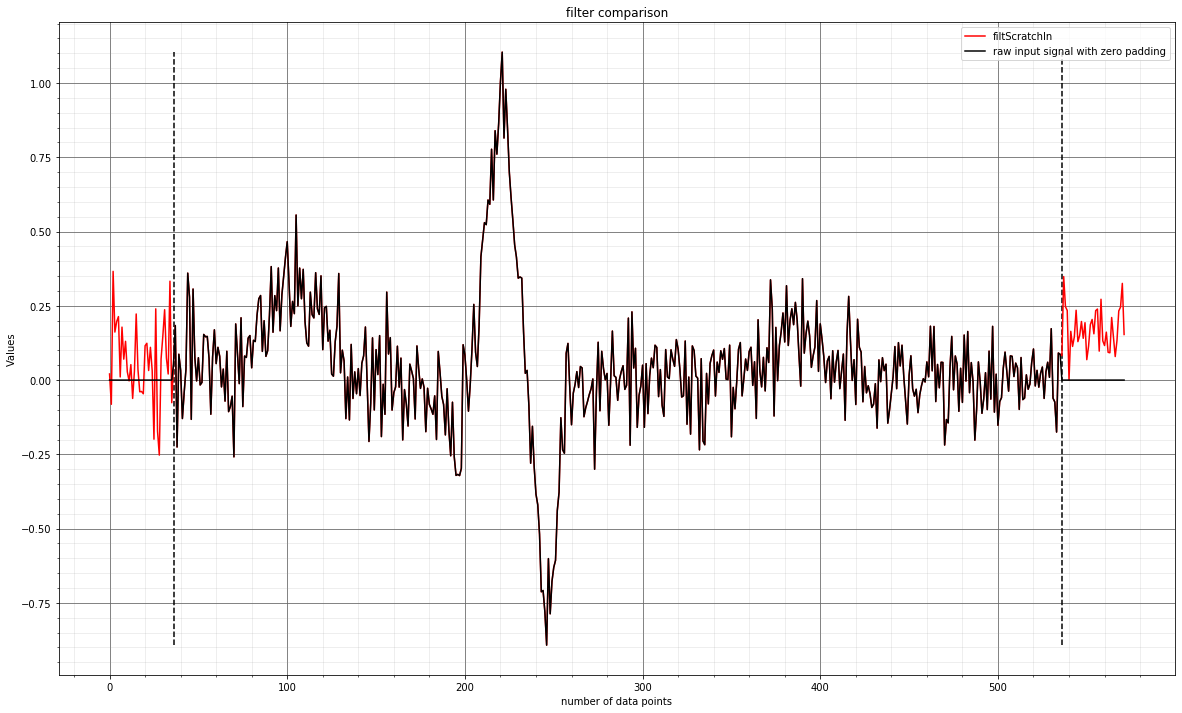

In [16]:
# plot comparison
fig, ax0 = plt.subplots(1, figsize=(20,12))

ax0.plot(index_plot, filtScratchIn, color='red', label ='filtScratchIn')
ax0.plot(index_plot, df_wform_noisy_comp, color='black', label ='raw input signal with zero padding')
ax0.vlines(x=nFact, ymin=min(filtScratchIn), ymax=max(filtScratchIn), color='black', linestyles='dashed')
ax0.vlines(x=length+nFact, ymin=min(filtScratchIn), ymax=max(filtScratchIn), color='black', linestyles='dashed') 

ax0.set_title('filter comparison')
ax0.set_xlabel('number of data points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


### isolated test of: Signal Reversion (used in filtfilt)

In [17]:
input_array = [0,1,2,3,4,5,6,7,8,9]
input_array_rev = np.zeros((len(input_array),))

for i in range(0, len(input_array)):
    input_array_rev[i] = input_array[ len(input_array) -i -1 ]
    
print(input_array)
print(input_array_rev)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[9. 8. 7. 6. 5. 4. 3. 2. 1. 0.]


# Notes

In [18]:
na = len(df_den_filt)
nb = len(df_den_filt)
nfilt = max(na,nb)          # 
nfact = max(1,3*(nfilt-1))  # length of edge transients

# zero pad shorter coeff arrays as needed
if (nb < nfilt):
    b = np.zeros((nfilt,))
#    b = []
#    for i in range(0, nb):
#        b[i] = df_den_filt[i]
#    for i in range(nb,nfilt):
#        b[i] = 0
elif (na < nfilt):
    a = np.zeros((nfilt,))
#    a = []
#    for i in range(0, na):
#        a[i] = df_num_filt[i]
#    for i in range(nb,nfilt):
#        a[i] = 0